In [39]:
# Imports
import pandas as pd
import math
import time 
import numpy as np
import mrmr

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

import seaborn as sns

In [40]:
# Constants
DATA_PATH = 'NewGeneratedData/'
MODELS_PATH = 'Models/'

BATCH_SIZE = 64
EPOCHS = 100
NUM_FEATURES = 285
LEARNING_RATE = 0.0001

EARLY_STOP = False
EARLY_STOP_LEN = 5

RECORD = True   
FEATURE_SELECTOR = "None"

In [41]:
# Loading functions
def load_data_frame(txt):
    return pd.read_csv(DATA_PATH + txt + '.txt', header=None, sep='\s+')

In [42]:
FEATURES = load_data_frame("features")[0].to_list()

complete_set = load_data_frame("har_dataset")
complete_set.columns = FEATURES
train_set, test_set = train_test_split(complete_set, test_size=0.3, random_state=37)

train_set['activity'] = train_set['activity'].astype(int) - 1
test_set['activity'] = test_set['activity'].astype(int) - 1

activity_labels = load_data_frame('activity_labels')
activity_labels.columns = ['id', 'activity']
activity_labels['id'] = activity_labels['id'].astype(int) - 1

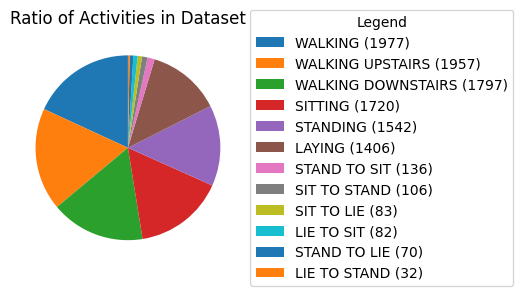

In [43]:
for i in range(0, len(activity_labels.activity)):
    activity_labels.activity[i] = activity_labels.activity[i].replace("_", " ")

# Assuming 'complete_set' is a DataFrame and 'activity_labels' is another DataFrame or list
value_counts = complete_set['activity'].value_counts()
activity_labels = activity_labels['activity']

# Creating the pie chart without labels on the slices
plt.figure(figsize=(3, 3))
wedges, texts = plt.pie(value_counts, startangle=90)

# Create the legend with labels and corresponding counts
legend_labels = [f'{label} ({count})' for label, count in zip(activity_labels, value_counts)]
plt.legend(wedges, legend_labels, title="Legend", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title('Ratio of Activities in Dataset')
plt.show()

In [19]:
# Creating model
device = None

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

class OurModel(nn.Module):
    def __init__(self):
        super(OurModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=NUM_FEATURES, out_features=1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.05),

            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.05),

            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.05),

            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.05),

            nn.Linear(in_features=128, out_features=12),
            nn.BatchNorm1d(12),
            
            nn.Softmax(dim=1)
        )


    def forward(self, x):
        return self.model(x)
    
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(NUM_FEATURES, 256, 2, batch_first=True) 
        self.sequential = nn.Sequential(
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.05),

            nn.Linear(in_features=128, out_features=12),
            nn.ReLU(),
            nn.BatchNorm1d(12),
            
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(2, x.size(0), 256).to(x.device)  # (num_layers, batch_size, hidden_size)
        c0 = torch.zeros(2, x.size(0), 256).to(x.device)  # (num_layers, batch_size, hidden_size)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Use the last output of the sequence
        out = out[:, -1, :]  # (batch_size, hidden_size)

        # Pass through fully connected layer
        return self.sequential(out)

In [20]:
model = OurModel().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [21]:
# Training and testing function
def train(dataloader, model, loss_fn, optimizer):
    # Get batch num
    num_batches = len(dataloader.dataset) / BATCH_SIZE
    i = 0

    # Set the model to train mode
    model.train()

    # For early stopping
    tracking_prev_loss = []

    for batch, (X, y) in enumerate(dataloader):
        # X = X.unsqueeze(1)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (EARLY_STOP):
            if len(tracking_prev_loss) == 0: 
                tracking_prev_loss.append(loss.item())
            else:
                if tracking_prev_loss[-1] >= loss.item():
                    tracking_prev_loss.append(loss.item())
                    if len(tracking_prev_loss) == EARLY_STOP_LEN:
                        return
                else:
                    tracking_prev_loss = []

        i += 1
        if batch % 50 == 0:
            print(f"loss: {loss.item()}, batch: {i} out of {math.ceil(num_batches)}")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    true_labels, pred_labels = [], []

    with torch.no_grad():
        for X, y in dataloader:
            # X = X.unsqueeze(1)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            true_labels.extend(y.tolist())
            pred_labels.extend(pred.argmax(1).tolist())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return (f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"), confusion_matrix(true_labels, pred_labels)

In [22]:
# Dataset preparation
class HAPTDataset(Dataset):
    def __init__(self, dataset, features, label):
        self.data = torch.tensor(dataset[features].values, dtype=torch.float32)
        self.labels = torch.tensor(dataset[label].values, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

selected_columns = None
if FEATURE_SELECTOR != "None":  
    kbest_selector = SelectKBest(score_func=mutual_info_classif, k=NUM_FEATURES)
    selected_features = kbest_selector.fit_transform(complete_set[complete_set.columns[:-1]], complete_set['activity'])
    selected_columns = complete_set.columns[:-1][kbest_selector.get_support()]
    print(selected_columns)

    train_dataset = HAPTDataset(train_set, selected_columns, 'activity')
    test_dataset = HAPTDataset(test_set, selected_columns, 'activity')
else:
    train_dataset = HAPTDataset(train_set, train_set.columns[:-1], 'activity')
    test_dataset = HAPTDataset(test_set, train_set.columns[:-1], 'activity')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [23]:
perf_timer = time.perf_counter()
perf_acc, conf_matrix = None, None
perf_list = []

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_function, optimizer)
    perf_acc, conf_matrix = test(test_dataloader, model, loss_function)
    perf_list.append(perf_acc)

print(perf_acc)
perf_timer = time.perf_counter() - perf_timer
percent_conf_matrix = 100 * conf_matrix.astype('float')/ conf_matrix.sum(axis=1)[:, np.newaxis]
print("Done!")

Epoch 1
-------------------------------
loss: 2.511094570159912, batch: 1 out of 120
loss: 2.245509147644043, batch: 51 out of 120
loss: 2.17279052734375, batch: 101 out of 120
Epoch 2
-------------------------------
loss: 2.231588840484619, batch: 1 out of 120
loss: 2.13374662399292, batch: 51 out of 120
loss: 2.180380344390869, batch: 101 out of 120
Epoch 3
-------------------------------
loss: 2.118177890777588, batch: 1 out of 120
loss: 2.1280622482299805, batch: 51 out of 120
loss: 2.0975308418273926, batch: 101 out of 120
Epoch 4
-------------------------------
loss: 2.095720052719116, batch: 1 out of 120
loss: 2.1023926734924316, batch: 51 out of 120
loss: 2.1090378761291504, batch: 101 out of 120
Epoch 5
-------------------------------
loss: 2.068167209625244, batch: 1 out of 120
loss: 2.0750584602355957, batch: 51 out of 120
loss: 2.066545009613037, batch: 101 out of 120
Epoch 6
-------------------------------
loss: 2.094684600830078, batch: 1 out of 120
loss: 2.09067797660827

KeyboardInterrupt: 

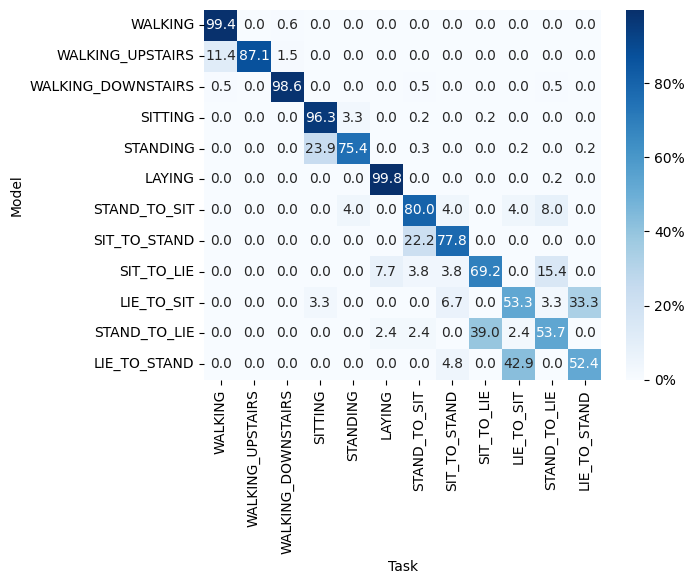

In [ ]:
plot = sns.heatmap(percent_conf_matrix, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'format': '%.0f%%'}, xticklabels=activity_labels.activity, yticklabels=activity_labels.activity)
plot.set_xlabel("Task")
plot.set_ylabel("Model")

if RECORD:
    torch.save(model.state_dict(), MODELS_PATH + "Model_" + FEATURE_SELECTOR + ".pth")

    with open(MODELS_PATH + "Model_" + FEATURE_SELECTOR + ".txt", "w") as f:
        f.write("Epochs: {}\n".format(EPOCHS))
        f.write("Feature Selection: {}\n".format(FEATURE_SELECTOR))
        f.write("Feature Set: {}\n".format(selected_columns))
        f.write("Model: {}\n".format(str(model)))
        f.write("Loss Function: {}\n".format("Cross Entropy Loss"))
        f.write("Optimizer: {}\n\n\n\n".format(str(optimizer)))
        f.write("Results: {}\n".format(perf_acc))
        f.write("Timer: {}s\n".format(round(perf_timer, 2)))
        f.write("Confusion Matrix\n")
        f.write(str(conf_matrix))
        f.close()

    plot.get_figure().savefig(MODELS_PATH + "Model_" + FEATURE_SELECTOR + "_Matrix.png")